In [1]:
import os, glob
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import leaves_list

In [2]:
pth = os.path.join('..', '..')
pth_data = os.path.join(pth, 'data')
pth_attr = os.path.join(pth_data, 'modeling', 'attribution')
pth_feat = os.path.join(pth_data, 'features', 'biomart')
pth_out = os.path.join(pth, 'figures', 'modeling', 'attribution')

In [3]:
adata = sc.read_h5ad(os.path.join(pth_attr, 'development.h5ad'))
adata

AnnData object with n_obs × n_vars = 143369 × 856
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations', 'celltype', 'trajectory', 't', 'training', 'validation', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'plates', 'devtime', 'location', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden', 'total_counts_ribo', 'pct_counts_ribo', 'T+ Sox2+', 'batch', 'percent_mito', 'n_counts', 'bh_pval', 'region', 'tissue', 'adj_stage', 'adj_sample', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'celltype_original', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.1', 'seurat_clusters', 'age', 'RNA_snn_res.0.5', 'ident', 'velocity_self_transition', 'source', 'weight_celltype', 'weight_source', 'weight', 'latent_z'
    obsm: 'X_diff', 'X_draw_gr

In [4]:
feat_fn = sorted(glob.glob(os.path.join(pth_feat, '*.csv')))
df = pd.read_csv(os.path.join(pth_data, 'summary.csv'), index_col = 0)
get_source = lambda fn: os.path.split(fn)[1].replace('.csv', '')
feat_dict = {get_source(fn) : fn for fn in feat_fn if 'union' not in fn}
for src, fn in feat_dict.items():
    print(src)
    df_feat = pd.read_csv(fn)
    g = df_feat.mmusculus.copy()
    g = g.loc[g.isin(adata.var_names)]
    ig = adata[:, g].layers['IG_z'].sum(axis = 1)
    adata.obs[src] = np.asarray(ig).squeeze()

EMTHallmark
GSE136689
GSE162534
GSE201257
GSE229103
HCAEmbryonicHindlimb
rRNAModifications


In [5]:
# attributions (training/validation celltypes)
msk_train = (adata.obs.training == 'True')
msk_val = (adata.obs.validation == 'True')
by = ['source', 'celltype']
grp = (adata[(msk_train | msk_val)].obs
       .groupby(by, observed = True)
       .filter(lambda g: len(g) > 200)
       .groupby(by, observed = True))
attr = grp[list(feat_dict.keys())].mean()
z = grp.latent_z.mean()

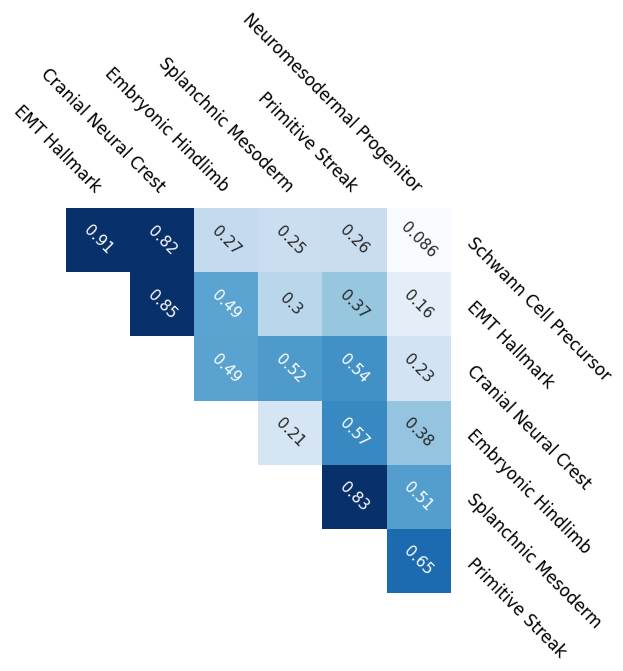

In [6]:
# correlations
R = attr.corr()
names = df.loc[R.index].Name
R.index = names.values
R.columns = names.values
ix = leaves_list(linkage(
    R, method = 'complete',
    optimal_ordering = True))
R = R.iloc[ix, ix].iloc[:-1, 1:]

# plot heatmap
fs1, fs2, rot, pad = 12, 11, -45, 10
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sns.heatmap(
    R, mask = (np.triu(R) == 0),
    cmap = 'Blues', annot = True,
    square = True, cbar = False,
    annot_kws = {'fontsize' : fs2,
                 'rotation' : rot},
    vmax = .82, ax = ax)

ax.set_yticklabels(ax.get_yticklabels(),
                   size = fs1, rotation = rot,
                   rotation_mode = 'anchor',
                   ha = 'left', va = 'center')
ax.set_xticklabels(ax.get_xticklabels(),
                   size = fs1, rotation = rot,
                   rotation_mode = 'anchor',
                   ha = 'right', va = 'center')
ax.tick_params('y', pad = pad,
               labelright = True,
               left = False,
               labelleft = False)
ax.tick_params('x', pad = pad,
               labeltop = True,
               bottom = False,
               labelbottom = False)
fn = os.path.join(pth_out, 'correlations.pdf')
plt.savefig(fn, bbox_inches = 'tight')

Top module:  HCAEmbryonicHindlimb


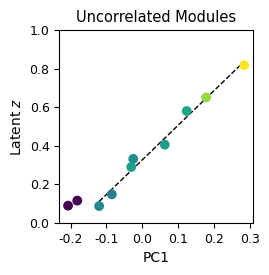

In [15]:
# uncorrelated modules
src_pca = [
    'GSE162534',
    'GSE229103',
    'HCAEmbryonicHindlimb',
    'rRNAModifications']

# PCA decomposition
X = attr.loc[src_pca, src_pca]
pca = PCA(n_components = 1).fit(X)
pc1 = pd.Series(pca.transform(X).flatten(),
                index = X.index, name = 'PC1')
ix_top = pca.components_[0].argmax()
src_color = src_pca[ix_top]
print('Top module: ', src_color)

# PC1 vs. latent z (scatter)
s, c, z_plt = 50, X[src_color], z.loc[pc1.index]
fig, ax = plt.subplots(1, 1, figsize = (2.5, 2.5))
ax.scatter(pc1, z_plt, c = c, s = s, linewidth = 0)

# least squares line
xx = pc1.sort_values().iloc[2:]
yy = z_plt.loc[xx.index]
m, b = np.polyfit(xx, yy, 1)
xx_plt = xx.iloc[[0, -1]]
yy_plt = m * xx_plt + b
ax.plot(xx_plt, yy_plt,
        c = 'k',
        ls = '--',
        linewidth = 1,
        zorder = 0)

ax.set_ylim(0, 1)
xticks = np.arange(-.2, .31, .1).round(1)
yticks = np.arange(0, 1.1, .2).round(1)
ax.set_xticks(xticks, xticks, size = 9)
ax.set_yticks(yticks, yticks, size = 9)
ax.set_title('Uncorrelated Modules', size = 10.5)
ax.set_xlabel('PC1', size = 10)
ax.set_ylabel(r'Latent $z$', size = 10)
fn = os.path.join(pth_out, 'decomposition.pdf')
plt.savefig(fn, bbox_inches = 'tight')